## Neural ODEの練習問題

「Neural ODE の練習のためにイチローのレーザービームをTensorFlowで計算する」をTensorflow 2.0で書き直す。<br>
https://qiita.com/yymgt/items/7acf934bb7d6846441fa


## 問題設計

$z_3$:T秒後のx軸位置、$z_4$:T秒後のy軸位置、x軸方向の抵抗はなし、y軸方向は重力のみとし、<br>
$z(t) = (z_1(t),z_2(t),z_3(t),z_4(t))^T$とする。<br>
$z$の時間発展は以下で得られる。<br>


$$\frac{dz}{dt} = f(z) = \left[\begin{array}{c}
            z_3 \\
            z_4 \\
            0 \\
            -g
        \end{array}\right]$$

$c=(c_1,c_2)^T=(v_0, \phi)$は初期パラメタを表し、<br>
$z(0) = (0,0,v_0 cos\phi, v_1 sin\phi)^T = (0,0,c_1 cosc_2, c_1 sinc_2)$を初期条件とする。

ここで損失関数$L$は<br>
$$L = (z_1(T)-x^*)^2 + (z_2(T)-y^*)^2$$

従って$L$を最小化する$c$を最急降下法によって探索する。<br>
$$c:=c-\epsilon \frac{\partial L}{\partial c}$$


## 指針

順方向(forward)の計算は以下の通りでODEソルバーを利用して解く事ができる。

$$z(T) = z(0) + \int_{t_0}^T f(\tau, z(\tau))d\tau$$

ただし損失関数$L$から$\partial L/\partial z(T)$、$z(0)$から$\partial z(0)/\partial c$は計算できるが、逆方向(backward)の計算ができない。<br>（NNの離散的な場面では微分のチェインルールで計算できた）
$$\frac{\partial L}{\partial z(0)} \leftarrow \frac{\partial L}{\partial z(T)}$$

ここで$a(t)$を以下のように定義、$a(t)$の時間発展を導入し、逆向きのODEを解く。<br>

$$ a(t) = \frac{\partial L}{\partial z(t)} $$
$$a(0) = a(T) + \int_{T}^{t_0} f'(\tau, a(\tau))d\tau$$

$a(t)$の時間発展は以下で与えられる。

$$\frac{da(t)}{dt} = -a(t)\frac{\partial f(z(t),t)}{\partial z}$$


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from scipy.integrate import solve_ivp
from scipy import cos, sin

In [2]:
def f(t,z):
    g = 9.8
    return (tf.concat( [z[2:4],[0,-g]],axis=0))

def jacobian(t, f, x):
    with tf.GradientTape() as g:
      g.watch(x)
      y = f(0,x)
    return g.jacobian(y, x)

def Df(t, f, x):
    return jacobian(t,f,x)
    
# test code
#Df(None, f, tf.constant([1.0,1.0,1.0,1.0])).numpy()

In [3]:
def L(x):
    return tf.reduce_sum(tf.square(x[0:2]-xy_target))

def dLdz_T(z_T):
    with tf.GradientTape() as g:
      g.watch(z_T)
      y = L(z_T)
    return g.gradient(y, z_T)


# test code
# xy_target = (100.0,0.0)
# print(dLdz_T(tf.constant([2.0,3.0])))

In [4]:
def f_np(t, z):
    return f(0, z)

def forward(z_0,ts=None):
    sol = solve_ivp(fun=f_np ,t_span=[0, t_end], y0=z_0, t_eval=ts)
    zt_val = sol['y']
    z_T_val = sol['y'][:,-1]  # ODEを解いた最後の値 z(T)を取り出す．
    L_val = L(z_T_val)
    return L_val, z_T_val, zt_val


# #forward calculation
# L_val, z_T_val, zt_val = forward(z_0, ts=ts)

# # z_0 and c value
# z0_val = z_0
# c_val = c

# # change to degree
# print('(v_0, phi(deg)) = ({:.4}, {:.4}'.format(c_val[0], 360*c_val[1]/(2*np.pi)))
# np.set_printoptions(3)
# print('z(0)={}'.format(z0_val))

# # z(T)
# print('z(T)={}'.format(z_T_val))
# print('L= {}'.format(L_val))

# plt.plot(zt_val[0,:],zt_val[1,:])
# plt.xlabel('x')
# plt.ylabel('y')

In [5]:
def f_with_adj(t, za):
    
    fzv = f(0, za[0:dim])
    dav = -tf.linalg.matvec(Df(0,f,tf.Variable(za[0:dim])), tf.Variable(za[dim:2*dim]), transpose_a=True)

    return np.concatenate([fzv, dav])

def backward(z_T_val):
    dLdz_T_val = dLdz_T(z_T_val)
    za_val[0:dim] = z_T_val[0:dim]
    za_val[dim:2*dim] = dLdz_T_val[:]

    # backward integration
    sol_back = solve_ivp(fun=f_with_adj,t_span=[t_end, 0], y0= za_val, t_eval=ts[::-1])
    za_0_val = sol_back['y'][:,-1]
    dLdz_0_val = za_0_val[dim:2*dim]
    
    Ldummy0 = lambda : tf.reduce_sum(
        dLdz_0_val * tf.concat([tf.Variable([0,0,],dtype=tf.float64), [c[0]*tf.cos(c[1])], [c[0]*tf.sin(c[1])]], axis=0))
    
    opt = tf.keras.optimizers.SGD(learning_rate=0.00001)
    opt.minimize(Ldummy0, var_list=[c])
    
    c_val = c
    return c_val, dLdz_T_val, dLdz_0_val, za_0_val

# c = tf.keras.backend.variable([35,np.pi/4], dtype=tf.float64) # set initial speed and angle here 
# z_0 = tf.concat([tf.Variable([0,0,],dtype=tf.float64), [c[0]*tf.cos(c[1])], [c[0]*tf.sin(c[1])]], axis=0)
# c_val, dLdz_T_val, dLdz_0_val, za_0_val = backward(tf.constant(z_T_val))
# print('dL/dz(T) = {}'.format(dLdz_T_val))
# print('dL/dz(0) = {}'.format(dLdz_0_val))
# print('(v_0, phi(deg)) = ({:.3}, {:.3})'.format(c_val[0], 360*c_val[1]/(2*np.pi)))

In [6]:
xy_target = (100,0) # target
t_end = 3 # duration of integration
ts=np.arange(0,t_end+0.1,0.1) # time step for displaying orbit
dim=4 # dimension of ode

c = tf.keras.backend.variable([35,np.pi/4], dtype=tf.float64, name='c') # set initial speed and angle here 
z_0 = tf.concat([tf.Variable([0,0,],dtype=tf.float64), [c[0]*tf.cos(c[1])], [c[0]*tf.sin(c[1])]], axis=0)
z_val = np.zeros(shape=[dim], dtype=np.float64)
za_val = np.zeros(shape=[dim*2],dtype=np.float64)

In [7]:
orbits = []
n_itr = []



for i in range(11):
    
    print("c="+str(c))
    L_val,z_T_val, zt_val = forward(z_0)
    c_val, *other = backward(tf.Variable(z_T_val))

    print(z_T_val)
    
    z_0 = tf.concat([tf.Variable([0,0],dtype=tf.float64), [c_val.numpy()[0]*tf.cos(c_val.numpy()[1])], [c_val.numpy()[0]*tf.sin(c_val.numpy()[1])]], axis=0)

    L_val,z_T_val, zt_val = forward(z_0, ts=ts)
    print('iteration:{}'.format(i))
    print('(v_0[m/s], phi[deg]) = ({:.10}, {:.10})'.format(c_val[0], 360*c_val[1]/(2*np.pi)))
    print('L= {:.4}'.format(L_val))
    print('z(T)={}'.format(z_T_val))
        
    orbits.append(zt_val)
    n_itr.append(i)

c=<tf.Variable 'c:0' shape=(2,) dtype=float64, numpy=array([35.        ,  0.78539816])>
[74.24621202 30.14621202 24.74873734 -4.65126266]
iteration:0
(v_0[m/s], phi[deg]) = (34.99981365, 40.24403416)
L= 957.5
z(T)=[80.14604621 23.73431192 26.71534874 -6.78856269]
c=<tf.Variable 'c:0' shape=(2,) dtype=float64, numpy=array([34.99981365,  0.7023909 ])>
[80.14604621 23.73431192 26.71534874 -6.78856269]
iteration:1
(v_0[m/s], phi[deg]) = (34.99980291, 36.52096533)
L= 582.0
z(T)=[84.38163588 18.38692152 28.12721196 -8.57102616]
c=<tf.Variable 'c:0' shape=(2,) dtype=float64, numpy=array([34.99980291,  0.63741109])>
[84.38163588 18.38692152 28.12721196 -8.57102616]
iteration:2
(v_0[m/s], phi[deg]) = (34.99989946, 33.62470728)
L= 355.2
z(T)=[ 87.43141427  14.04365364  29.14380476 -10.01878212]
c=<tf.Variable 'c:0' shape=(2,) dtype=float64, numpy=array([34.99989946,  0.58686185])>
[ 87.43141427  14.04365364  29.14380476 -10.01878212]
iteration:3
(v_0[m/s], phi[deg]) = (35.0000608, 31.38027123)
L

Text(0, 0.5, 'y')

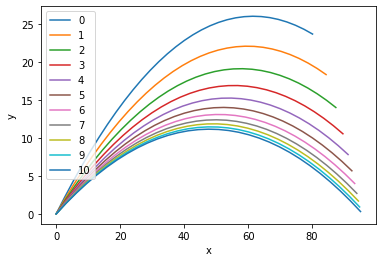

In [8]:
orbits[0].shape
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
for ( i,orb) in zip(n_itr,orbits):
    ax.plot(orb[0],orb[1], label=i)
ax.legend(loc = 'upper left')
ax.set_xlabel('x')
ax.set_ylabel('y')